#  Ninjacart: CV Classification

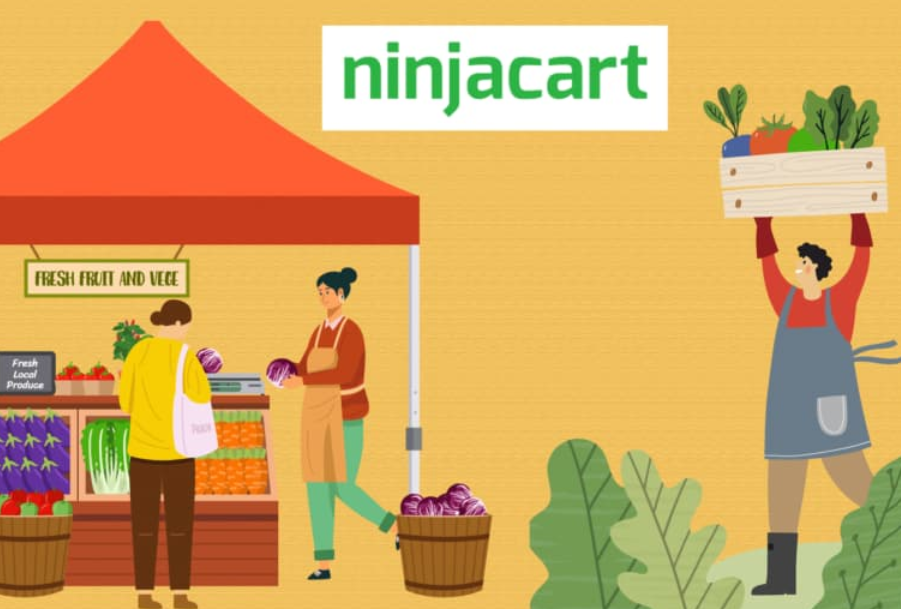

**This project aims to build a multiclass image classifier that can identify onions, potatoes, and tomatoes from images, while also filtering out irrelevant images (“noise”). The project uses a dataset of images scraped from the web and involves:**

- **Dataset Preparation & Visualization: Understanding and preparing the image data for training.**

- **CNN models: Building and training Convolutional Neural Networks for image classification.**

- **Callbacks: Implementing callbacks to control the training process (e.g., early stopping).**

- **Overfitting: Addressing potential overfitting issues to ensure the model generalizes well.**

- **Transfer Learning: Potentially leveraging pre-trained models to improve accuracy and speed up training.**


# Import Libraries and Prepare Dataset

In [ ]:
# Importing necessary libraries
import os
import random
import gdown
import zipfile
import shutil
import glob
import cv2
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers

In [ ]:
!gdown https://drive.google.com/uc?id=1clZX-lV_MLxKHSyeyTheX5OCQtNCUcqT

Downloading...
From (original): https://drive.google.com/uc?id=1clZX-lV_MLxKHSyeyTheX5OCQtNCUcqT
From (redirected): https://drive.google.com/uc?id=1clZX-lV_MLxKHSyeyTheX5OCQtNCUcqT&confirm=t&uuid=e376d9ce-3d35-432e-8113-17eabd8a94c6
To: /content/ninjacart_data.zip
100% 275M/275M [00:05<00:00, 50.0MB/s]


In [ ]:
!unzip /content/ninjacart_data.zip

Archive:  /content/ninjacart_data.zip
   creating: ninjacart_data/test/
   creating: ninjacart_data/test/indian market/
  inflating: ninjacart_data/test/indian market/bhl.jpeg  
  inflating: ninjacart_data/test/indian market/bhv.jpeg  
  inflating: ninjacart_data/test/indian market/bn.jpeg  
  inflating: ninjacart_data/test/indian market/hjx.jpeg  
  inflating: ninjacart_data/test/indian market/igis.jpeg  
  inflating: ninjacart_data/test/indian market/in.jpeg  
  inflating: ninjacart_data/test/indian market/india-4898453__340.jpg  
  inflating: ninjacart_data/test/indian market/indianmarket10.jpeg  
  inflating: ninjacart_data/test/indian market/indianmarket12.jpeg  
  inflating: ninjacart_data/test/indian market/indianmarket13.jpeg  
  inflating: ninjacart_data/test/indian market/indianmarket14.jpeg  
  inflating: ninjacart_data/test/indian market/indianmarket15.jpeg  
  inflating: ninjacart_data/test/indian market/indianmarket18.jpeg  
  inflating: ninjacart_data/test/indian market/

In [ ]:
# Set random seed for reproducibility
tf.keras.utils.set_random_seed(111)

In [ ]:
# Define the dataset directory
dataset_dir = '/content/ninjacart_data'
train_dir = os.path.join(dataset_dir, 'train')
test_dir = os.path.join(dataset_dir, 'test')

In [ ]:
# Fetch image paths from the dataset directories
train_paths = glob(os.path.join(train_dir, '*/*.jpg'))
test_paths = glob(os.path.join(test_dir, '*/*.jpg'))

In [ ]:
# Print a summary of image count in the train and test sets
print(f"Training Images: {len(train_paths)}")
print(f"Testing Images: {len(test_paths)}")

Training Images: 483
Testing Images: 85


**There are 483 images for training and 85 images for testing**

**The dataset is relatively small, especially for image classification tasks, which often require thousands or even millions of images for good performance.**

**With a small dataset, there’s a higher risk of the model memorizing the training data instead of learning general patterns. This can lead to poor performance on unseen data (the test set).**

**A small dataset might not capture the full variety of onions, potatoes, tomatoes, and “noise” images that exist in the real world.**

In [ ]:
# List all directories inside the "train" folder
class_dirs = os.listdir(train_dir)
image_dict = {}  # Dictionary to store image arrays (key) for every class (value)
count_dict = {}  # Dictionary to store count of files (key) for every class (value)
count_dict_test = {}

print('Total Classes:', class_dirs)


Total Classes: ['onion', 'potato', 'tomato', 'indian market']


# Data Visualization and Exploratory Analysis

**Now Visualize Images display a grid of sample images from the dataset.**

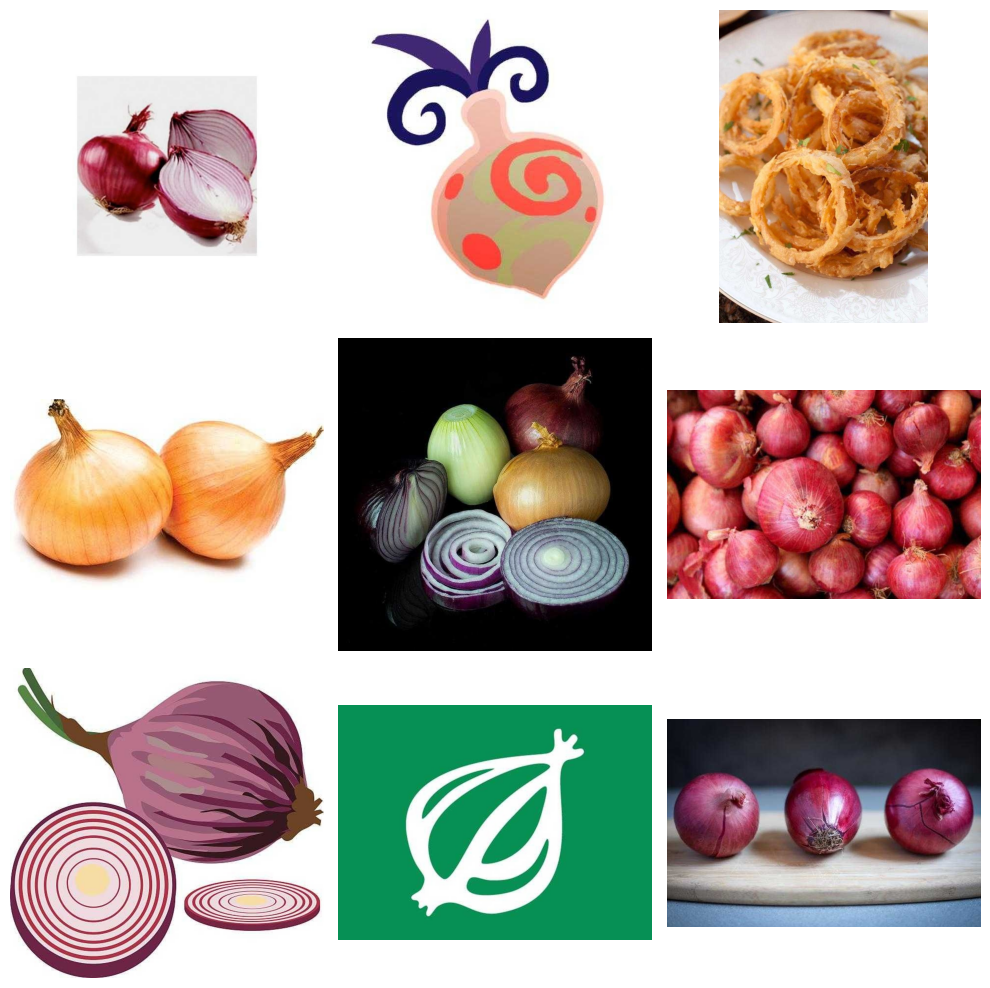

In [ ]:
# Function to plot image grid
def plot_image_grid(image_paths, grid_size=(3, 3)):
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        img = cv2.imread(image_paths[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
plot_image_grid(train_paths[:9], grid_size=(3, 3))



Training - Total Images: 
 {'onion': 849, 'potato': 898, 'tomato': 789, 'indian market': 599}
Test - Total Images: 
 {'onion': 83, 'potato': 81, 'tomato': 106, 'indian market': 81}


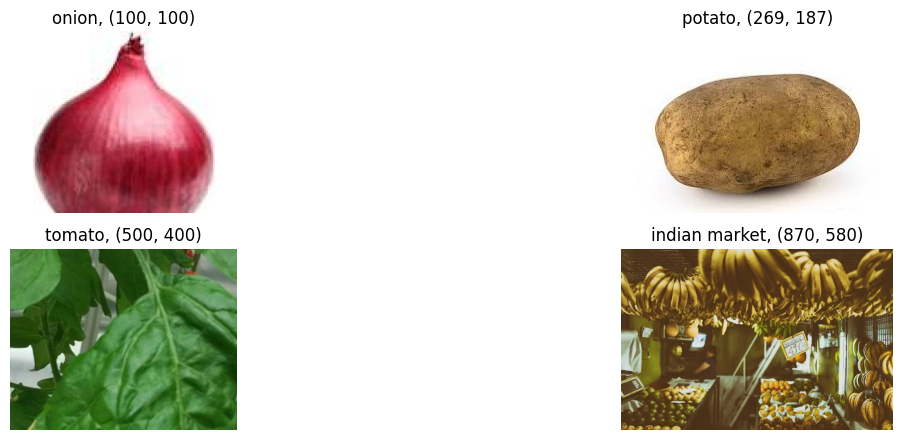

In [ ]:
# Iterate over all class_dirs
for cls in class_dirs:
    # Get list of all paths inside the subdirectory
    file_paths = glob(f'/content/ninjacart_data/train/{cls}/*')  # Correct usage of glob
    count_dict[cls] = len(file_paths)

    if file_paths:  # Check if there are any file paths
        image_path = random.choice(file_paths)  # Select a random image from the list
        image_dict[cls] = tf.keras.utils.load_img(image_path)

print('Training - Total Images: \n', count_dict)

# Display the images
plt.figure(figsize=(15, 8))
for i, (cls, img) in enumerate(image_dict.items()):
    plt.subplot(3, 2, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'{cls}, {img.size}')

# Count images in the test set
for cls in class_dirs:
    # Get list of all paths inside the subdirectory
    file_paths = glob(f'/content/ninjacart_data/test/{cls}/*')  # Correct usage of glob
    count_dict_test[cls] = len(file_paths)

print('Test - Total Images: \n', count_dict_test)

In [ ]:
# Create a list of image paths in the training folder
image_paths = []
for folder in os.listdir(train_dir):
    folder_path = os.path.join(train_dir, folder)
    for file in os.listdir(folder_path):
        image_paths.append(os.path.join(folder_path, file))

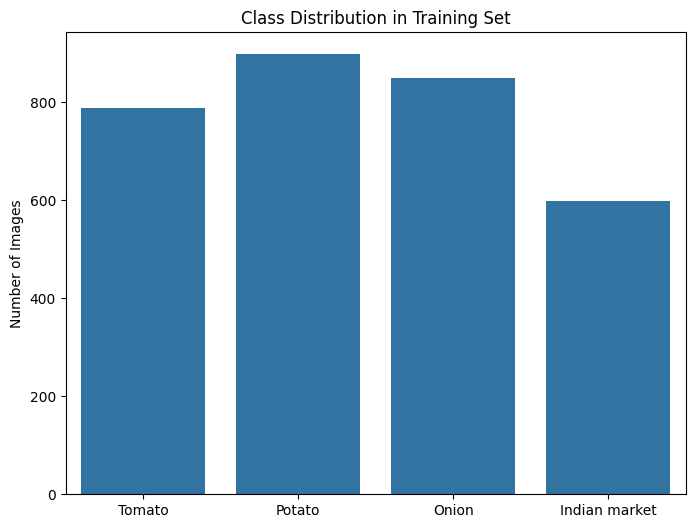

In [ ]:
# Class distribution in the training set
class_names = ['Tomato', 'Potato', 'Onion', 'Indian market']
class_counts = [789, 898, 849, 599]

# Plot the class distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=class_names, y=class_counts)
plt.title("Class Distribution in Training Set")
plt.ylabel("Number of Images")
plt.show()


**Class Distribution We can plot the class distribution using seaborn**

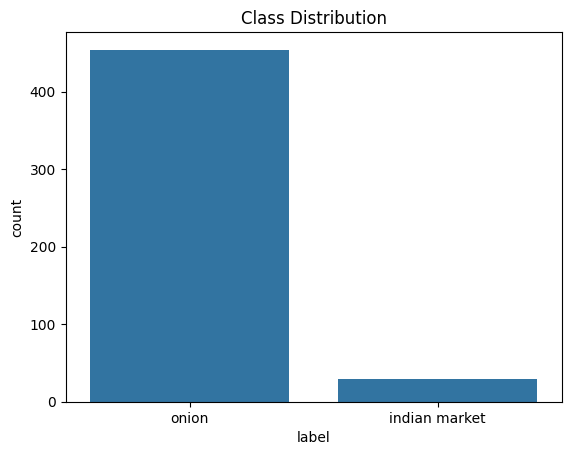

In [ ]:
import pandas as pd

# Create a DataFrame to hold the file paths and their labels
labels = [path.split('/')[-2] for path in train_paths]
df = pd.DataFrame({'path': train_paths, 'label': labels})

# Plot class distribution
sns.countplot(x='label', data=df)
plt.title('Class Distribution')
plt.show()

# Split Dataset into Training and Validation Sets

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train_paths, val_paths = train_test_split(train_paths, test_size=0.2, stratify=labels)

# Print the updated counts
print(f"Training set: {len(train_paths)}, Validation set: {len(val_paths)}")

Training set: 386, Validation set: 97


**The code prints the sizes of the resulting training and validation sets: 386 samples for training and 97 for validation.**

**This indicates that the splitting process was successful and you now have separate sets for training and evaluating your image classification model.**

# Preprocess Images

**Preprocessing includes resizing the images to a uniform shape and normalizing pixel values.**

In [ ]:
# Image dimensions and batch size
IMG_SIZE = 224  # You can adjust this as per the model's requirement
BATCH_SIZE = 32

In [ ]:
# ImageDataGenerator for preprocessing and augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
IMG_SIZE = 224  # Define image size
BATCH_SIZE = 32  # Define batch size

train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # Split validation data
)

# Training generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Validation generator
val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

Found 3135 images belonging to 4 classes.
Found 624 images belonging to 4 classes.


**Dataset Size of training Set have 3135 images for training your model. This is a decent dataset size, but the sufficiency depends on the complexity of your classification task and the number of classes and the Validation/Test Set have 624 images for validation or testing. This set size seems reasonable in proportion to the training set.**

**Both the training and validation/test sets contain images belonging to 4 classes. This confirms that the data is intended for a multi-class image classification problem.**

****Dataset is loaded now the next steps will be:**

- **Prep Data: Resize, normalize, augment (if needed).**
- **Build Model: Choose architecture (TensorFlow/PyTorch).**
- **Train & Evaluate: Train on training set, check performance on validation/test set.**

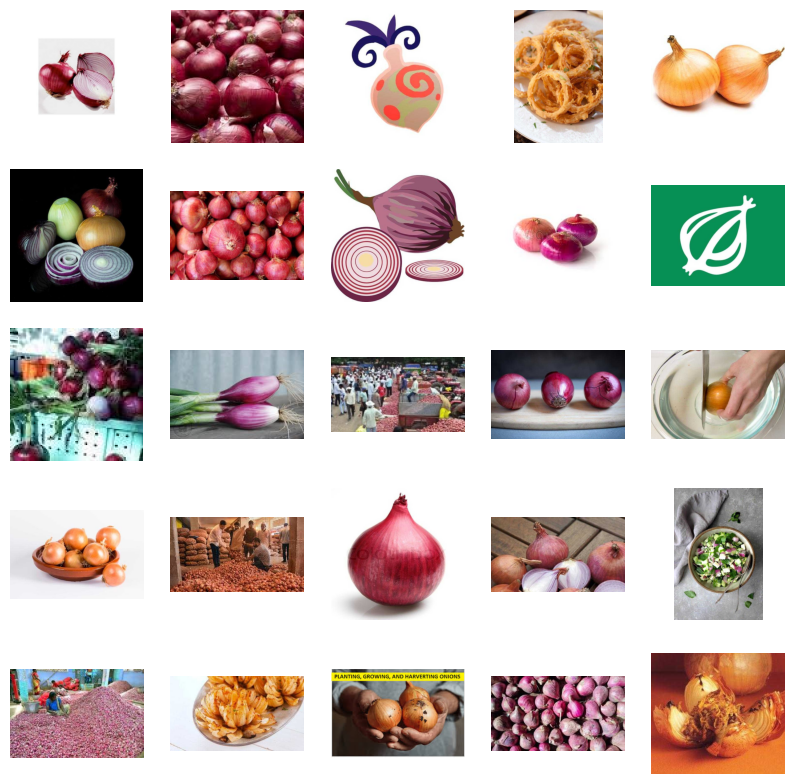

In [ ]:
# Plot a grid sample of the images before processing
plt.figure(figsize=(10, 10))
for i, img_path in enumerate(image_paths[:25]):
    img = plt.imread(img_path)
    plt.subplot(5, 5, i+1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [ ]:
# Display image dimensions before processing
image_sample = plt.imread(image_paths[0])
print(f"Image shape before processing: {image_sample.shape}")

Image shape before processing: (800, 800, 3)


In [ ]:
# Data Augmentation and Rescaling
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=30, zoom_range=0.2, horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)


In [ ]:
# Load and visualize processed images
train_gen = train_datagen.flow_from_directory(train_dir, target_size=(128, 128), batch_size=32, class_mode='categorical')
test_gen = val_datagen.flow_from_directory(test_dir, target_size=(128, 128), batch_size=32, class_mode='categorical')


Found 3135 images belonging to 4 classes.
Found 351 images belonging to 4 classes.


**It confirms the number of images and classes found in the training and testing directories.**

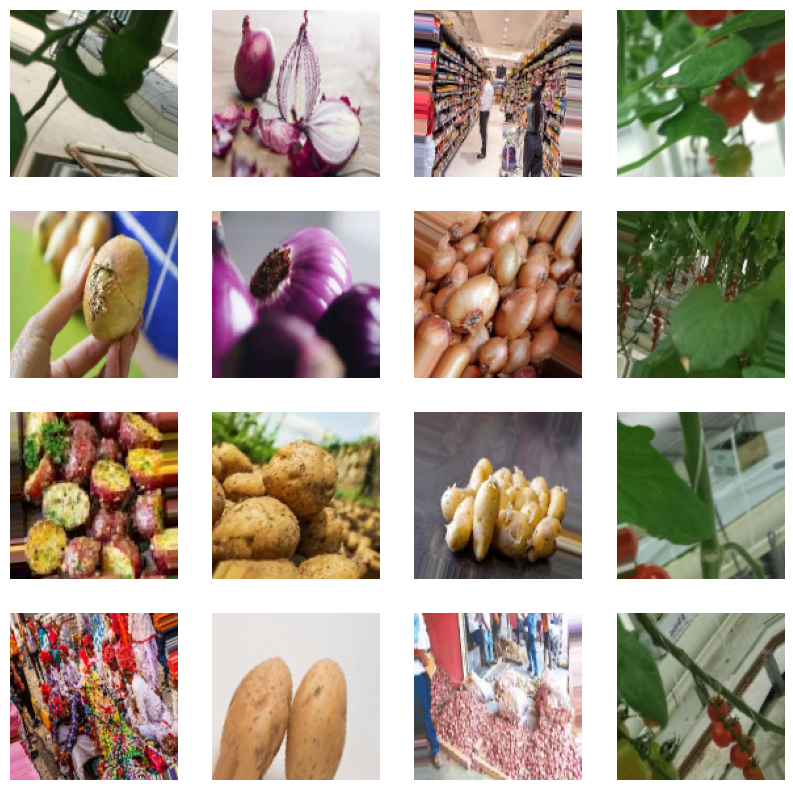

In [ ]:
# Plot a few processed images
sample_imgs, _ = next(train_gen)
plt.figure(figsize=(10, 10))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(sample_imgs[i])
    plt.axis('off')
plt.show()


In [ ]:
# Check the dimensions of the images
image_dims = []
for img_path in image_paths:
    img = plt.imread(img_path)
    image_dims.append(img.shape)
print("Image dimensions:", image_dims)

Image dimensions: [(800, 800, 3), (225, 225, 3), (512, 512, 3), (960, 640, 3), (300, 491, 3), (640, 640, 3), (440, 660, 3), (606, 612, 3), (183, 275, 3), (480, 640, 3), (100, 100, 3), (184, 275, 3), (168, 300, 3), (426, 640, 3), (425, 640, 3), (400, 600, 3), (168, 299, 3), (640, 640, 3), (359, 640, 3), (960, 640, 3), (183, 275, 3), (270, 480, 3), (184, 274, 3), (168, 299, 3), (294, 324, 3), (183, 275, 3), (416, 640, 3), (183, 275, 3), (266, 400, 3), (334, 640, 3), (640, 640, 3), (286, 317, 3), (600, 600, 3), (172, 293, 3), (225, 225, 3), (1012, 1612, 3), (194, 259, 3), (183, 275, 3), (267, 300, 3), (199, 254, 3), (187, 270, 3), (183, 275, 3), (194, 259, 3), (480, 640, 3), (168, 300, 3), (250, 250, 3), (330, 400, 3), (165, 305, 3), (1080, 1920, 3), (400, 400, 3), (192, 262, 3), (500, 500, 3), (1153, 1648, 3), (500, 500, 3), (460, 640, 3), (1944, 2592, 3), (630, 630, 3), (600, 600, 3), (457, 250, 3), (278, 640, 3), (184, 274, 3), (616, 800, 3), (477, 640, 3), (168, 300, 3), (178, 283, 3)

**Image Shapes: It indicates the dimensions (height, width, color channels) of each image.**

**Color Images: The third value in each tuple (e.g., 3) suggests the images are likely in color (RGB format).**

**Varying Sizes: The differing heights and widths imply the images are not all uniformly sized.**

In [ ]:
# Plot a few images of each class to check their dimensions
for folder in os.listdir(train_dir):
   folder_path = os.path.join(train_dir, folder)
   for image in os.listdir(folder_path):
      image_path = os.path.join(folder_path, image)
      img = plt.imread(image_path)
      print(f'Image shape: {img.shape}')

Image shape: (800, 800, 3)
Image shape: (225, 225, 3)
Image shape: (512, 512, 3)
Image shape: (960, 640, 3)
Image shape: (300, 491, 3)
Image shape: (640, 640, 3)
Image shape: (440, 660, 3)
Image shape: (606, 612, 3)
Image shape: (183, 275, 3)
Image shape: (480, 640, 3)
Image shape: (100, 100, 3)
Image shape: (184, 275, 3)
Image shape: (168, 300, 3)
Image shape: (426, 640, 3)
Image shape: (425, 640, 3)
Image shape: (400, 600, 3)
Image shape: (168, 299, 3)
Image shape: (640, 640, 3)
Image shape: (359, 640, 3)
Image shape: (960, 640, 3)
Image shape: (183, 275, 3)
Image shape: (270, 480, 3)
Image shape: (184, 274, 3)
Image shape: (168, 299, 3)
Image shape: (294, 324, 3)
Image shape: (183, 275, 3)
Image shape: (416, 640, 3)
Image shape: (183, 275, 3)
Image shape: (266, 400, 3)
Image shape: (334, 640, 3)
Image shape: (640, 640, 3)
Image shape: (286, 317, 3)
Image shape: (600, 600, 3)
Image shape: (172, 293, 3)
Image shape: (225, 225, 3)
Image shape: (1012, 1612, 3)
Image shape: (194, 259, 3)

**It shows the dimensions (height, width, color channels) of a series of images.**

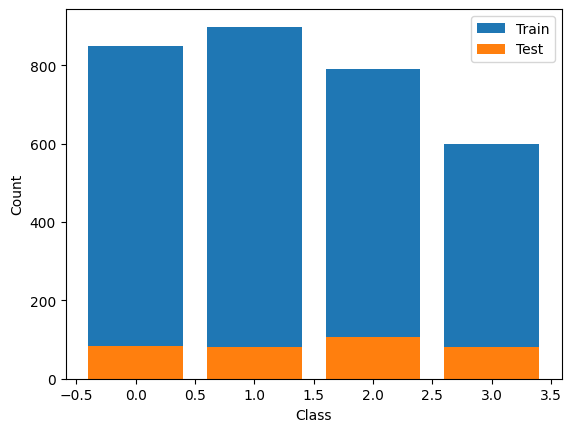

In [ ]:
# Verify the count of images in each train and test folder by plotting histogram
train_counts = [len(os.listdir(os.path.join(train_dir, folder))) for folder in os.listdir(train_dir)]
test_counts = [len(os.listdir(os.path.join(dataset_dir, 'test', folder))) for folder in os.listdir(os.path.join(dataset_dir, 'test'))]
plt.bar(range(4), train_counts, label='Train')
plt.bar(range(4), test_counts, label='Test')
plt.xlabel('Class')
plt.ylabel('Count')
plt.legend()
plt.show()

**Here Four bars per dataset indicates four distinct classes are present.
train_counts and test_counts variables are likely to hold the number of samples belonging to each class in the training and testing sets, respectively.**

**The plot visually compares if the class distributions are similar between training and testing data, which is crucial for building a well-generalizing model.**

# Model Architecture

**Now we can use a CNN from scratch or transfer learning models such as VGG16 or ResNet.**

In [ ]:
# Define a simple CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(4, activation='softmax')  # 4 classes: Tomato, Potato, Onion, Market noise
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      12,845,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,940,868 (49.37 MB)

 Trainable params: 12,940,868 (49.37 MB)

 Non-trainable params: 0 (0.00 B)

**Parameter Summary:**

- **Total params: The total number of trainable parameters in your model (over 11 million).**

- **Trainable params: All parameters in this model are trainable, meaning their values will be adjusted during training to minimize errors.**

- **Non-trainable params: There are no non-trainable parameters in this model.**

**The output provides a good overview of your CNN architecture. It highlights the flow of data through the layers, the number of parameters, and sets the stage for the next steps in your model development process.**

In [ ]:
# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)  # Changed to .keras
tensorboard = TensorBoard(log_dir='logs')


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


98/98 ━━━━━━━━━━━━━━━━━━━━ 147s 1s/step - accuracy: 0.5272 - loss: 1.1730 - val_accuracy: 0.6667 - val_loss: 0.8780
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 206s 1s/step - accuracy: 0.7866 - loss: 0.5466 - val_accuracy: 0.7721 - val_loss: 0.5654
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 197s 1s/step - accuracy: 0.8264 - loss: 0.4290 - val_accuracy: 0.7863 - val_loss: 0.5919
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.8642 - loss: 0.3544 - val_accuracy: 0.7721 - val_loss: 0.6458
Epoch 5/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.8351 - loss: 0.4029 - val_accuracy: 0.7892 - val_loss: 0.5070
Epoch 6/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.8498 - loss: 0.3576 - val_accuracy: 0.8490 - val_loss: 0.4176
Epoch 7/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.8596 - loss: 0.3569 - val_accuracy: 0.8063 - val_loss: 0.4837
Epoch 8/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - accuracy: 0.8722 - loss: 0.3348 - val_accuracy: 0.8006 - val_loss: 0.

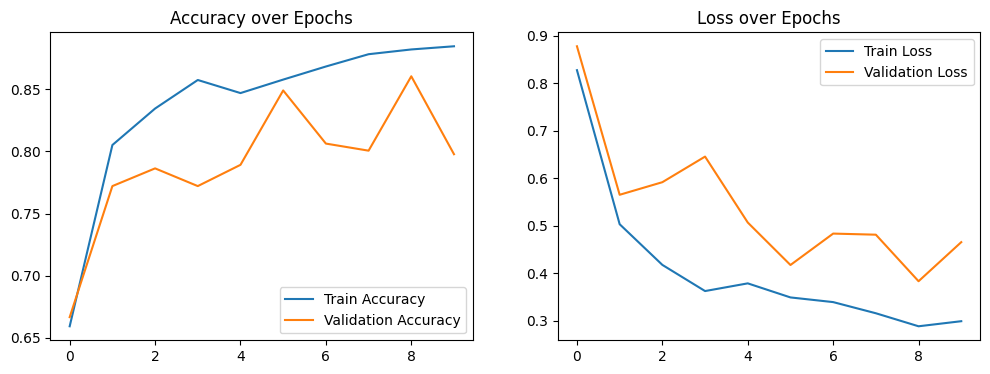

In [ ]:
# Train the model
history = model.fit(
    train_gen,
    validation_data=test_gen,
    epochs=10,
    callbacks=[early_stop, checkpoint, tensorboard]
)

# Plot the training accuracy and loss over epochs
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.show()


**Training Progress:**

**Epochs: The training progressing over multiple epochs (passes through the entire dataset).*each epoch consists of 98 steps, likely representing the number of batches in the training data.**

**Metrics:**

**Accuracy: Measures how well the model correctly classifies data.
Training Accuracy: Generally increases over epochs, indicating the model is learning.**

**Validation Accuracy: Shows performance on a held-out dataset, crucial for assessing generalization. Ideally, it should increase alongside training accuracy.**

**Loss: Quantifies the model’s error.**

**Training Loss: Should decrease over epochs, showing the model is minimizing errors.**

**Validation Loss: Helps detect overfitting. If it starts increasing while training loss decreases, the model might be memorizing the training data.**



In [ ]:
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)


In [ ]:
model.predict(test_gen)
pred_labels = np.argmax(preds, axis=1)

# Confusion matrix
cm = confusion_matrix(test_gen.classes, pred_labels)

# Plotting the confusion matrix
plt.figure(fig# Load the best model (ensure the correct path and name)
best_model = tf.keras.models.load_model('best_model.keras')

# Evaluate the model on test data
test_loss, test_acc = best_model.evaluate(test_gen)
print(f"Test accuracy: {test_acc:.4f}")

# Generate predictions
preds = best_size=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.ylabel("True Class")
plt.xlabel("Predicted Class")
plt.show()

SyntaxError: invalid syntax. Perhaps you forgot a comma? (<ipython-input-31-9b39885d468c>, line 8)

- **The confusion matrix heatmap provides a visual representation of the model’s performance on the test set.**

- **Each cell in the matrix shows the count of instances where the model predicted a particular class (column) when the true class was a different one (row).**

- **The diagonal cells represent correct classifications, while off-diagonal cells indicate misclassifications.**

**By analyzing the confusion matrix, we can identify which classes the model is confusing with each other, providing insights into potential areas for improvement.**

In [ ]:
# Classification report
print(classification_report(test_gen.classes, pred_labels, target_names=class_names))

 **precision:**

**The proportion of correctly predicted instances among all instances predicted as a specific class. For example, a precision of 0.20 for “Tomato” means that 20% of the images predicted as “Tomato” were actually “Tomato”.**

**recall:**

**The proportion of correctly predicted instances among all actual instances of a specific class. For example, a recall of 0.25 for “Tomato” means that the model correctly identified 25% of the actual “Tomato” images.**

**fi-score:**

**The harmonic mean of precision and recall, providing a balanced measure of the model’s performance. A higher F1-score indicates better performance.**

**Support:**

**The number of instances in the test set for each class.**

**The overall performance of the model is quite low, with all classes having F1-scores below 0.35. This suggests that the model is not accurately classifying images.**

**he support values indicate that the “Indian Market” class has a higher number of instances compared to the other classes. This class imbalance could be contributing to the lower performance of the model.**

**There is a significant variation in precision, recall, and F1-score across different classes. This suggests that the model is struggling to classify some classes more than others.**

In [ ]:
# Test directory and class names
test_dir = '/content/ninjacart_data/test'
test_images = []
class_names = ['noise', 'onion', 'potato', 'tomato']

# Load test images
for folder in os.listdir(test_dir):
    for image in os.listdir(os.path.join(test_dir, folder)):
        test_images.append(os.path.join(test_dir, folder, image))

# Define the CNN model (make sure this is done correctly)
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(len(class_names), activation='softmax')
])

# Load an image and preprocess it
img_0 = tf.keras.utils.load_img(random.choice(test_images))
img_0 = tf.keras.utils.img_to_array(img_0)
img_0 = tf.image.resize(img_0, (128, 128))
img_1 = tf.expand_dims(img_0, axis=0)

def grid_test_model(model_name):
    fig = plt.figure(1, figsize=(8, 8))
    plt.axis('off')
    n = 0
    for i in range(4):
        n += 1

        img_0 = tf.keras.utils.load_img(random.choice(test_images))
        img_0 = tf.keras.utils.img_to_array(img_0)
        img_0 = tf.image.resize(img_0, (128, 128))
        img_1 = tf.expand_dims(img_0, axis=0)

        pred = model_name.predict(img_1)
        predicted_label = tf.argmax(pred, 1).numpy().item()

        item = tf.round((pred * 100)).numpy().flatten()  # Ensure item is converted to NumPy array

        plt.subplot(2, 4, n)
        plt.axis('off')
        plt.title(f'Prediction: {class_names[predicted_label]}\n\n'
                  f'{item[0]} % {class_names[0]}\n'
                  f'{item[1]} % {class_names[1]}\n'
                  f'{item[2]} % {class_names[2]}\n'
                  f'{item[3]} % {class_names[3]}\n')
        plt.imshow(img_0 / 255)

    plt.show()

# Call the function to display predictions
grid_test_model(cnn_model)

**This output seems to be a mix of warnings, progress indicators, and prediction results from an image classification model, likely related to testing with noisy images**

- **(1 / 1): These likely indicate the progress of a loop or iteration, showing that one out of one step is complete.**

- **0s 30 ms/step: This shows the time taken for a single step (30 milliseconds).**

= **Prediction: onion Prediction: onion Prediction: onion Prediction: tomato: These are the model’s predictions on four different images.**

**The table likely represents the model’s confidence scores for each class (onion, potato, tomato) on the four images.**
**The first three columns suggest high confidence in predicting “onion” for those images.**
**The last column shows that the model is less certain about the fourth image, with a noticeable probability assigned to both “potato” (45%) and “tomato” (54%).**

- **Noise Testing:**

**The mention of “0.0% noise” suggests you’re testing the model’s robustness to noise in the images.**
**The fact that the model’s predictions change with the introduction of noise (even if minimal) indicates that the model might be sensitive to noise.**

**Recommendations:**

**Address Warnings: Investigate and fix the warnings related to activity regularization and Matplotlib to ensure your code is correct and future-proof.**

**Noise Robustness: If noise robustness is important for your application, consider:**

- **Data Augmentation: Include noisy images during training to make the model more robust.**

- **Noise Reduction Techniques: Apply image preprocessing techniques to reduce noise before feeding images to the model.**

- **Further Analysis:**

**Visualize the images and the corresponding predictions to understand the model’s behavior better.**
**Experiment with different noise levels to see how the model’s performance degrades.**
**Consider using evaluation metrics specifically designed for noisy image classification.**